In [20]:

!pip -q install snowflake-connector-python pandas matplotlib


In [21]:

import os
import getpass
import pandas as pd
import matplotlib.pyplot as plt


pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)


In [22]:

SF_ACCOUNT   = input('SNOWFLAKE_ACCOUNT (e.g. xpc24435.us-east-1): ').strip()
SF_USER      = input('SNOWFLAKE_USER (e.g. DM_SVC): ').strip()
SF_PASSWORD  = getpass.getpass('SNOWFLAKE_PASSWORD: ').strip()
SF_ROLE      = input('SNOWFLAKE_ROLE (e.g. ROLE_DM_SVC): ').strip()
SF_WAREHOUSE = input('SNOWFLAKE_WAREHOUSE (e.g. WH_DM): ').strip()
SF_DATABASE  = input('SNOWFLAKE_DB (e.g. DM_NYCTLC): ').strip()
SF_SCHEMA    = input('SNOWFLAKE_SCHEMA (e.g. SILVER_GOLD): ').strip()


SNOWFLAKE_ACCOUNT (e.g. xpc24435.us-east-1): xpc24435.us-east-1
SNOWFLAKE_USER (e.g. DM_SVC): DM_SVC
SNOWFLAKE_PASSWORD: ··········
SNOWFLAKE_ROLE (e.g. ROLE_DM_SVC): ROLE_DM_SVC
SNOWFLAKE_WAREHOUSE (e.g. WH_DM):  WH_DM
SNOWFLAKE_DB (e.g. DM_NYCTLC):  DM_NYCTLC
SNOWFLAKE_SCHEMA (e.g. SILVER_GOLD): GOLD


In [23]:

import snowflake.connector

conn = snowflake.connector.connect(
    user=SF_USER,
    password=SF_PASSWORD,
    account=SF_ACCOUNT,
    role=SF_ROLE,
    warehouse=SF_WAREHOUSE,
    database=SF_DATABASE,
    schema=SF_SCHEMA,
    client_session_keep_alive=False,
)
cur = conn.cursor()

# Fijar contexto explícito por si acaso
cur.execute(f"USE ROLE {SF_ROLE}")
cur.execute(f"USE WAREHOUSE {SF_WAREHOUSE}")
cur.execute(f"USE DATABASE {SF_DATABASE}")
cur.execute(f"USE SCHEMA {SF_SCHEMA}")

print("✅ Conectado y contexto listo.")


✅ Conectado y contexto listo.


In [24]:

def q(sql: str) -> pd.DataFrame:
    cur.execute(sql)
    try:
        df = cur.fetch_pandas_all()
    except Exception:
        rows = cur.fetchall()
        cols = [c[0] for c in cur.description] if cur.description else []
        df = pd.DataFrame(rows, columns=cols)
    return df

def show(df: pd.DataFrame, n=10):
    display(df.head(n))


In [25]:

q("USE DATABASE DM_NYCTLC;")
q("USE SCHEMA SILVER_GOLD;")


print(q("SELECT CURRENT_DATABASE() db, CURRENT_SCHEMA() sch;"))
print(q("SHOW TABLES IN SCHEMA SILVER_GOLD;").head())


          DB          SCH
0  DM_NYCTLC  SILVER_GOLD
                        created_on       name database_name  schema_name  \
0 2025-10-05 11:49:07.959000-07:00   DIM_ZONE     DM_NYCTLC  SILVER_GOLD   
1 2025-10-05 13:05:09.300000-07:00  FCT_TRIPS     DM_NYCTLC  SILVER_GOLD   

        kind comment cluster_by      rows      bytes        owner  \
0  TRANSIENT                          265       6144  ROLE_DM_SVC   
1  TRANSIENT                     23232662  982517248  ROLE_DM_SVC   

  retention_time automatic_clustering change_tracking search_optimization  \
0              1                  OFF             OFF                 OFF   
1              1                  OFF             OFF                 OFF   

  search_optimization_progress search_optimization_bytes is_external  \
0                         None                      None           N   
1                         None                      None           N   

  enable_schema_evolution owner_role_type is_event is_hybrid i

In [26]:

df_info = q("""
SELECT COUNT(*) AS rows_total,
       MIN(pickup_datetime) AS min_dt,
       MAX(pickup_datetime) AS max_dt
FROM FCT_TRIPS
""")
show(df_info, 5)


,ROWS_TOTAL,MIN_DT,MAX_DT
0,23232662,2009-01-01 00:02:19,2019-09-29 13:54:19


In [27]:
q("USE DATABASE DM_NYCTLC;")
q("USE SCHEMA SILVER_GOLD;")


,status
0,Statement executed successfully.


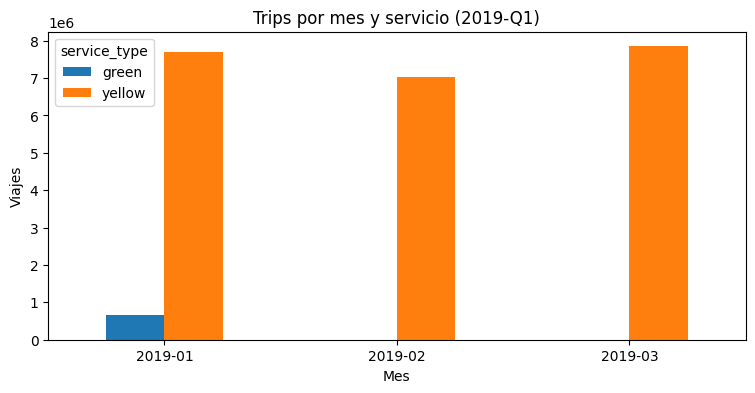

In [28]:
sql = """
SELECT
  TO_CHAR(TO_DATE(pickup_datetime), 'YYYY-MM') AS year_month,
  service_type,
  COUNT(*) AS trips,
  ROUND(SUM(total_amount), 2) AS revenue
FROM DM_NYCTLC.SILVER_GOLD.FCT_TRIPS
WHERE TO_DATE(pickup_datetime) BETWEEN '2019-01-01' AND '2019-03-31'
GROUP BY 1, 2
ORDER BY 1, 2
"""
df_a1.columns = [c.lower().strip() for c in df_a1.columns]
pivot_a1 = df_a1.pivot(index='year_month', columns='service_type', values='trips').fillna(0)
ax = pivot_a1.plot(kind='bar', figsize=(9,4), rot=0, title='Trips por mes y servicio (2019-Q1)')
ax.set_xlabel('Mes'); ax.set_ylabel('Viajes'); plt.show()

,BOROUGH,SERVICE_TYPE,TOTAL_REVENUE,AVG_TIP
0,Manhattan,yellow,3.234840e+08,1.85
1,Queens,yellow,6.662008e+07,5.33
2,Brooklyn,yellow,6.392569e+06,1.37
3,Unknown,yellow,5.294268e+06,2.03
4,Brooklyn,green,4.434551e+06,0.91
5,Queens,green,3.258949e+06,0.67
6,Manhattan,green,2.900687e+06,1.03
7,Bronx,yellow,1.595530e+06,0.28
8,Bronx,green,1.444221e+06,0.12
9,N/A,yellow,8.406743e+05,8.14


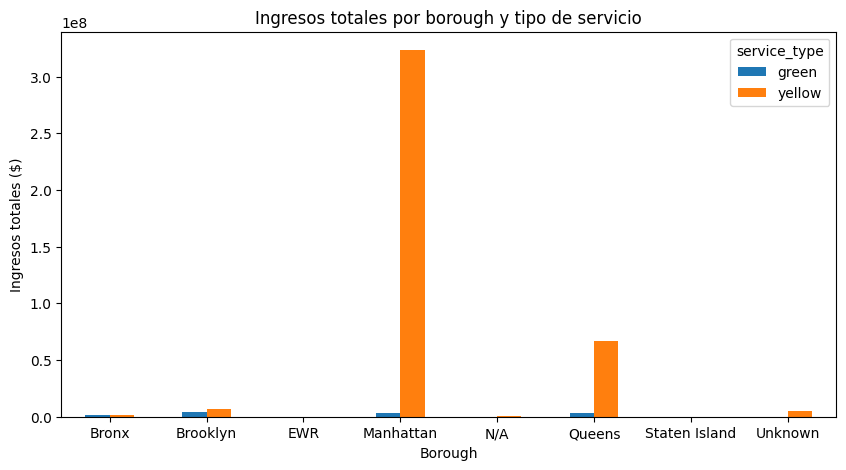

In [29]:

sql = """
SELECT
  pickup_borough AS borough,
  service_type,
  ROUND(SUM(total_amount), 2) AS total_revenue,
  ROUND(AVG(tip_amount), 2) AS avg_tip
FROM DM_NYCTLC.SILVER_GOLD.FCT_TRIPS
WHERE pickup_borough IS NOT NULL
GROUP BY 1, 2
ORDER BY total_revenue DESC
"""

df_a2 = q(sql)
show(df_a2, 10)


df_a2.columns = [c.lower().strip() for c in df_a2.columns]
pivot_a2 = df_a2.pivot(index='borough', columns='service_type', values='total_revenue').fillna(0)
ax = pivot_a2.plot(kind='bar', figsize=(10,5), rot=0, title='Ingresos totales por borough y tipo de servicio')
ax.set_xlabel('Borough'); ax.set_ylabel('Ingresos totales ($)')
plt.show()


,HORA_FR,SERVICE_TYPE,DURACION_PROMEDIO_MIN,VELOCIDAD_KMH
0,00-05,green,12.27,15.75
1,00-05,yellow,11.97,15.86
2,06-11,green,19.41,13.52
3,06-11,yellow,13.69,11.20
4,12-17,green,17.98,12.20
5,12-17,yellow,14.82,10.32
6,18-23,green,12.63,13.20
7,18-23,yellow,13.11,12.22


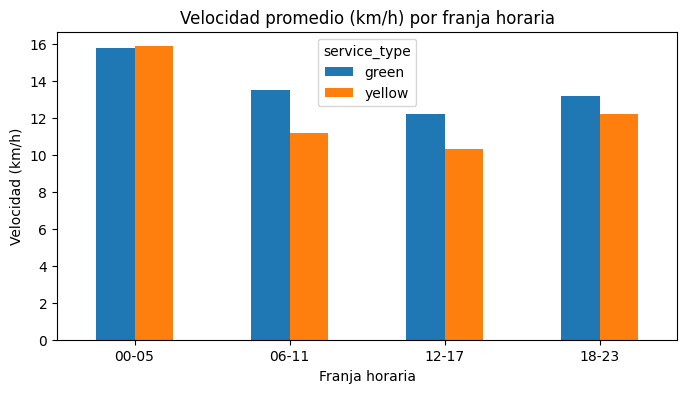

In [30]:


sql = """
SELECT
  CASE
    WHEN EXTRACT(HOUR FROM pickup_datetime) BETWEEN 0 AND 5 THEN '00-05'
    WHEN EXTRACT(HOUR FROM pickup_datetime) BETWEEN 6 AND 11 THEN '06-11'
    WHEN EXTRACT(HOUR FROM pickup_datetime) BETWEEN 12 AND 17 THEN '12-17'
    ELSE '18-23'
  END AS hora_fr,
  service_type,
  ROUND(AVG(DATEDIFF('minute', pickup_datetime, dropoff_datetime)), 2) AS duracion_promedio_min,
  ROUND(AVG(trip_distance / NULLIF(DATEDIFF('minute', pickup_datetime, dropoff_datetime),0)) * 60, 2) AS velocidad_kmh
FROM DM_NYCTLC.SILVER_GOLD.FCT_TRIPS
WHERE trip_distance > 0
  AND DATEDIFF('minute', pickup_datetime, dropoff_datetime) BETWEEN 1 AND 120
GROUP BY 1, 2
ORDER BY hora_fr, service_type
"""

df_a3 = q(sql)
show(df_a3, 10)


df_a3.columns = [c.lower().strip() for c in df_a3.columns]
pivot_a3 = df_a3.pivot(index='hora_fr', columns='service_type', values='velocidad_kmh').fillna(0)
ax = pivot_a3.plot(kind='bar', figsize=(8,4), rot=0, title='Velocidad promedio (km/h) por franja horaria')
ax.set_xlabel('Franja horaria'); ax.set_ylabel('Velocidad (km/h)')
plt.show()


,PICKUP_ZONE,SERVICE_TYPE,TRIPS
0,Upper East Side South,yellow,938403
1,Midtown Center,yellow,927332
2,Upper East Side North,yellow,886281
3,Midtown East,yellow,817349
4,Penn Station/Madison Sq West,yellow,785890
5,Times Sq/Theatre District,yellow,782541
6,Clinton East,yellow,720748
7,Union Sq,yellow,708106
8,Murray Hill,yellow,703050
9,Lincoln Square East,yellow,681109


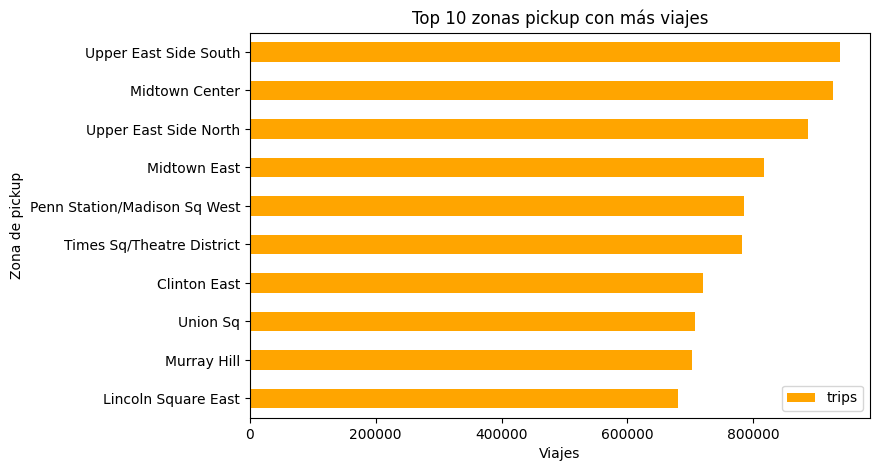

In [31]:


sql = """
SELECT
  pickup_zone,
  service_type,
  COUNT(*) AS trips
FROM DM_NYCTLC.SILVER_GOLD.FCT_TRIPS
WHERE pickup_zone IS NOT NULL
GROUP BY 1, 2
ORDER BY trips DESC
LIMIT 10
"""

df_a4 = q(sql)
show(df_a4, 10)

df_a4.columns = [c.lower().strip() for c in df_a4.columns]
ax = df_a4.plot(kind='barh', x='pickup_zone', y='trips', color='orange', figsize=(8,5), title='Top 10 zonas pickup con más viajes')
ax.set_xlabel('Viajes'); ax.set_ylabel('Zona de pickup')
plt.gca().invert_yaxis()
plt.show()


,DIA_SEMANA,HORA,VIAJES
0,0,0,153028
1,0,1,130833
2,0,2,95760
3,0,3,79296
4,0,4,48363
5,0,5,22127
6,0,6,27283
7,0,7,41421
8,0,8,65208
9,0,9,94011


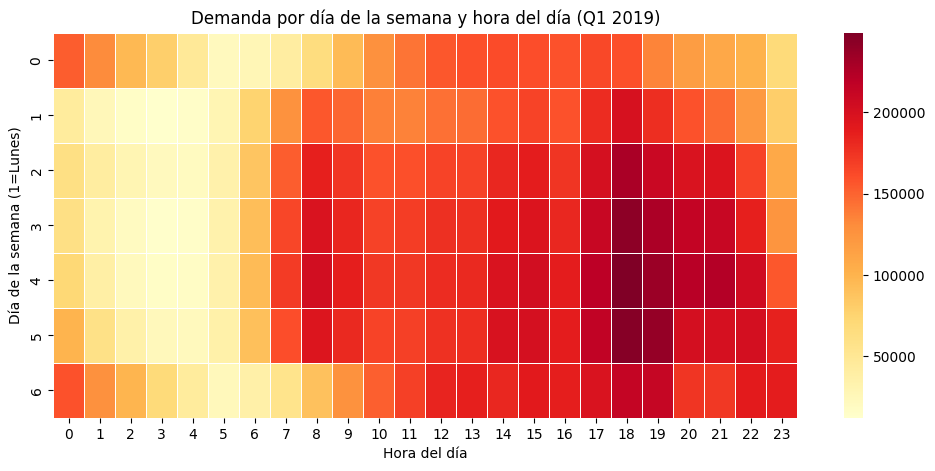

In [32]:


sql = """
SELECT
  DAYOFWEEK(pickup_datetime) AS dia_semana,
  EXTRACT(HOUR FROM pickup_datetime) AS hora,
  COUNT(*) AS viajes
FROM DM_NYCTLC.SILVER_GOLD.FCT_TRIPS
WHERE pickup_datetime BETWEEN '2019-01-01' AND '2019-03-31'
GROUP BY 1, 2
ORDER BY 1, 2
"""

df_a5 = q(sql)
show(df_a5, 10)

df_a5.columns = [c.lower().strip() for c in df_a5.columns]
pivot_a5 = df_a5.pivot(index='dia_semana', columns='hora', values='viajes').fillna(0)

import seaborn as sns
plt.figure(figsize=(12,5))
sns.heatmap(pivot_a5, cmap="YlOrRd", linewidths=.5)
plt.title('Demanda por día de la semana y hora del día (Q1 2019)')
plt.xlabel('Hora del día')
plt.ylabel('Día de la semana (1=Lunes)')
plt.show()
